In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
from typing import Dict, List, Text, Tuple, Callable

import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm import tqdm
import glob
import os
import tensorflow as tf

In [2]:

# Define dataset path
dataset_path = "ndws_western_dataset"

# Get all TFRecord files
tfrecord_files = sorted(glob.glob(os.path.join(dataset_path, "*.tfrecord")))

# Ensure TFRecord files exist
if not tfrecord_files:
    raise FileNotFoundError("No TFRecord files found in the dataset directory!")

print("Using TFRecord file:", tfrecord_files[0])

Using TFRecord file: ndws_western_dataset\cleaned_eval_ndws_conus_western_000.tfrecord


In [3]:
raw_dataset = tf.data.TFRecordDataset(tfrecord_files[0])
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    # Extract feature names (keys) only
    feature_names = list(example.features.feature.keys())
    
    print("Feature names in TFRecord:", feature_names)

Feature names in TFRecord: ['gust_med', 'wind_75', 'elevation', 'population', 'chili', 'impervious', 'fuel3', 'viirs_PrevFireMask', 'fuel2', 'viirs_FireMask', 'fuel1', 'pdsi', 'water', 'tmp_day', 'erc', 'NDVI', 'pr', 'wdir_wind', 'wdir_gust', 'bi', 'tmp_75', 'avg_sph', 'wind_avg']


In [4]:

# Feature description (using VarLenFeature to handle float lists)
feature_description = {
    'viirs_FireMask': tf.io.VarLenFeature(tf.float32),  
    'viirs_PrevFireMask': tf.io.VarLenFeature(tf.float32),
    'wind_75': tf.io.VarLenFeature(tf.float32),
    'pr': tf.io.VarLenFeature(tf.float32),
    'tmp_day': tf.io.VarLenFeature(tf.float32),
    'chili': tf.io.VarLenFeature(tf.float32),
    'wdir_wind': tf.io.VarLenFeature(tf.float32),
    'bi': tf.io.VarLenFeature(tf.float32),
    'water': tf.io.VarLenFeature(tf.float32),
    'fuel1': tf.io.VarLenFeature(tf.float32),
    'NDVI': tf.io.VarLenFeature(tf.float32),
    'wind_avg': tf.io.VarLenFeature(tf.float32),
    'fuel2': tf.io.VarLenFeature(tf.float32),
    'elevation': tf.io.VarLenFeature(tf.float32),
    'fuel3': tf.io.VarLenFeature(tf.float32),
    'tmp_75': tf.io.VarLenFeature(tf.float32),
    'gust_med': tf.io.VarLenFeature(tf.float32),
    'impervious': tf.io.VarLenFeature(tf.float32),
    'wdir_gust': tf.io.VarLenFeature(tf.float32),
    'pdsi': tf.io.VarLenFeature(tf.float32),
    'erc': tf.io.VarLenFeature(tf.float32),
    'avg_sph': tf.io.VarLenFeature(tf.float32),
    'population': tf.io.VarLenFeature(tf.float32),
}

# Input feature keys
input_features = [
    "elevation", "wind_75", "wind_avg", "tmp_75", "tmp_day",
    "avg_sph", "pr", "pdsi", "NDVI", "population", "erc",
    "viirs_PrevFireMask"
]




In [5]:
# Function to parse TFRecord
def parse_tfrecord(serialized_example):
    example = tf.io.parse_single_example(serialized_example, feature_description)

    # Convert sparse tensors to dense
    image = tf.stack([tf.sparse.to_dense(example[key], default_value=0.0) for key in input_features], axis=-1)

    # Reshape the image to expected spatial dimensions
    image = tf.reshape(image, (64, 64, len(input_features)))  # Update if different shape

    # Convert mask to dense tensor and reshape
    mask = tf.sparse.to_dense(example["viirs_FireMask"], default_value=0.0)
    mask = tf.reshape(mask, (64, 64)) if tf.size(mask) == 64*64 else tf.constant(0.0, dtype=tf.float32)

    return image, mask

# Load TFRecord dataset
raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
parsed_dataset = raw_dataset.map(parse_tfrecord)

# Debug: Print a few samples
for img, mask in parsed_dataset.take(3):
    print("Image shape:", img.numpy().shape, "Mask unique values:", np.unique(mask.numpy()))

# Convert to NumPy for PyTorch
def tfrecord_to_numpy(dataset, num_samples=100):
    images, masks = [], []
    for image, mask in dataset.take(num_samples):
        images.append(image.numpy())
        masks.append(mask.numpy())
    return np.array(images), np.array(masks)

# Convert dataset
#num_samples = 500  # Adjust based on memory
images_np, masks_np = tfrecord_to_numpy(parsed_dataset)

print("Converted TFRecord to NumPy!")
print("Images shape:", images_np.shape, "Masks shape:", masks_np.shape)

Image shape: (64, 64, 12) Mask unique values: [0. 1.]
Image shape: (64, 64, 12) Mask unique values: [0. 1.]
Image shape: (64, 64, 12) Mask unique values: [0. 1.]
Converted TFRecord to NumPy!
Images shape: (100, 64, 64, 12) Masks shape: (100, 64, 64)


In [6]:
import os
dataset_path = "ndws_western_dataset"

INPUT_FEATURES = ['elevation', 'wind_75', 'wind_avg', 'tmp_75', 'tmp_day', 'avg_sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'viirs_PrevFireMask']
OUTPUT_FEATURES = ['viirs_FireMask']  

train_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if "train" in f and f.endswith(".tfrecord")]
test_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if "test" in f and f.endswith(".tfrecord")]
validation_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if "eval" in f and f.endswith(".tfrecord")]


In [7]:
import os
import torch
import tensorflow as tf
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Define feature names
INPUT_FEATURES = ['elevation', 'wind_75', 'wind_avg', 'tmp_75', 'tmp_day', 'avg_sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'viirs_PrevFireMask']
OUTPUT_FEATURES = ['viirs_FireMask']

class WildfireDataset(Dataset):
    def __init__(self, tfrecord_files, feature_means=None, feature_stds=None, compute_stats=False):
        """
        Initialize the dataset by loading TFRecord files.

        Args:
            tfrecord_files (list): List of TFRecord file paths.
            feature_means (torch.Tensor): Precomputed means for normalization.
            feature_stds (torch.Tensor): Precomputed std devs for normalization.
            compute_stats (bool): If True, compute mean & std dev from dataset.
        """
        self.tfrecord_files = tfrecord_files
        self.dataset = self._load_tfrecords()
        self.data = list(self.dataset.as_numpy_iterator())  # Convert to list for PyTorch compatibility

        # Compute mean & std dev if required
        if compute_stats:
            self.feature_means, self.feature_stds = self._compute_feature_stats()
        else:
            self.feature_means = feature_means if feature_means is not None else torch.zeros(len(INPUT_FEATURES))
            self.feature_stds = feature_stds if feature_stds is not None else torch.ones(len(INPUT_FEATURES))

    def _load_tfrecords(self):
        """Loads and parses TFRecord files."""
        dataset = tf.data.TFRecordDataset(self.tfrecord_files)
        with tf.device('/CPU:0'):
            dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return dataset

    def _parse_function(self, example_proto):
        """Parses a single TFRecord example and returns PyTorch-compatible tensors."""
        feature_description = {
            name: tf.io.FixedLenFeature([64, 64], tf.float32) for name in INPUT_FEATURES + OUTPUT_FEATURES
        }
        
        parsed_example = tf.io.parse_single_example(example_proto, feature_description)

        # Convert TF tensors to NumPy and then to PyTorch
        def convert_to_torch(*features):
            features = [tf.reshape(f, [64, 64]).numpy() for f in features]  # Convert to NumPy
            inputs = np.stack(features[:len(INPUT_FEATURES)], axis=-1)  # Shape (64, 64, channels)
            label = np.expand_dims(features[-1], axis=-1)  # Shape (64, 64, 1)

            return inputs.astype(np.float32), label.astype(np.float32)

        # Extract input & label tensors
        feature_tensors = [parsed_example[name] for name in INPUT_FEATURES] + [parsed_example['viirs_FireMask']]

        # Use tf.numpy_function to ensure NumPy conversion
        #inputs, label = tf.numpy_function(func=convert_to_torch, inp=feature_tensors, Tout=[tf.float32, tf.float32])
        inputs = tf.stack(feature_tensors[:len(INPUT_FEATURES)], axis=-1)  # shape (64, 64, C)
        label = tf.expand_dims(feature_tensors[-1], axis=-1)  # shape (64, 64, 1)


        # Set static shape for PyTorch compatibility
        inputs.set_shape([64, 64, len(INPUT_FEATURES)])
        label.set_shape([64, 64, 1])

        return inputs, label

    def _compute_feature_stats(self):
        """Computes mean and std deviation of features from the dataset."""
        print("Computing mean & std deviation for dataset...")

        sum_features = torch.zeros(len(INPUT_FEATURES))
        sum_squares = torch.zeros(len(INPUT_FEATURES))
        num_pixels = 0

        for inputs, _ in self.data:
            inputs = torch.tensor(inputs)  # Convert to PyTorch tensor
            num_pixels += inputs.shape[0] * inputs.shape[1] * inputs.shape[2]  # Total pixels
            
            sum_features += inputs.sum(dim=[0, 1])  # Sum over spatial dimensions
            sum_squares += (inputs ** 2).sum(dim=[0, 1])  # Sum of squares

        feature_means = sum_features / num_pixels
        feature_stds = torch.sqrt((sum_squares / num_pixels) - (feature_means ** 2))

        print("Computed feature means:", feature_means)
        print("Computed feature std devs:", feature_stds)

        return feature_means, feature_stds

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieves a sample from the dataset and converts to PyTorch tensors."""
        inputs, label = self.data[idx]

        # Convert NumPy to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        # Normalize inputs
        inputs = (inputs - self.feature_means) / self.feature_stds

        return inputs, label


# 🔹 Load TFRecord file paths
train_files = [
    os.path.join("ndws_western_dataset", f)
    for f in os.listdir("ndws_western_dataset")
    if "train" in f and f.endswith(".tfrecord")
]

# 🔹 Compute Mean & Std from Training Data
temp_dataset = WildfireDataset(train_files, compute_stats=True)
feature_means, feature_stds = temp_dataset.feature_means, temp_dataset.feature_stds

# 🔹 Create Final Dataset with Normalization
train_dataset = WildfireDataset(train_files, feature_means=feature_means, feature_stds=feature_stds)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

# 🔹 Test a single batch
for batch in train_loader:
    inputs, labels = batch
    print(f"Normalized Input shape: {inputs.shape}, Label shape: {labels.shape}")
    break


Computing mean & std deviation for dataset...
Computed feature means: tensor([ 1.1119e+02,  2.7379e-01,  2.0647e-01,  1.8321e+00,  1.8032e+00,
         4.6063e-04,  1.3427e-02, -1.9269e-01,  4.4927e+02,  8.2134e-01,
         5.8971e+00,  2.8208e-03])
Computed feature std devs: tensor([4.2159e+02, 1.0310e+00, 7.8365e-01, 6.4602e+00, 6.3737e+00, 1.6279e-03,
        4.1043e-01, 9.2393e-01, 1.6152e+03, 3.8096e+01, 2.0459e+01, 5.3036e-02])
Normalized Input shape: torch.Size([16, 64, 64, 12]), Label shape: torch.Size([16, 64, 64, 1])


In [8]:
# Load test and validation TFRecord file paths
test_files = [
    os.path.join("ndws_western_dataset", f)
    for f in os.listdir("ndws_western_dataset")
    if "test" in f and f.endswith(".tfrecord")
]

validation_files = [
    os.path.join("ndws_western_dataset", f)
    for f in os.listdir("ndws_western_dataset")
    if "eval" in f and f.endswith(".tfrecord")
]

# Create PyTorch datasets
test_dataset = WildfireDataset(test_files)
validation_dataset = WildfireDataset(validation_files)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=0)

# Verify shapes for test and validation
for batch in test_loader:
    inputs, labels = batch
    print(f"Test Input shape: {inputs.shape}, Test Label shape: {labels.shape}")
    break

for batch in validation_loader:
    inputs, labels = batch
    print(f"Validation Input shape: {inputs.shape}, Validation Label shape: {labels.shape}")
    break


Test Input shape: torch.Size([16, 64, 64, 12]), Test Label shape: torch.Size([16, 64, 64, 1])
Validation Input shape: torch.Size([16, 64, 64, 12]), Validation Label shape: torch.Size([16, 64, 64, 1])


In [9]:
BATCH_SIZE = 8

# Train DataLoader with shuffling and prefetching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



In [10]:

# Debug the dataset
batch = next(iter(train_loader))  # Get a batch
inputs, labels = batch

print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

Inputs shape: torch.Size([8, 64, 64, 12])
Labels shape: torch.Size([8, 64, 64, 1])


In [11]:
# Updated feature titles to match dataset
TITLES_WITH_UNITS = [
    "Precipitation\n(mm, daily total)",  # pr
    "Wind\nspeed at 75m\n(m/s)",         # wind_75
    "Energy\nrelease component\n(index)",# erc
    "Population\ndensity\n(people per km²)",  # population
    "Water\n(% cover)",                   # water
    "Wind\ngust direction\n(degree)",      # wdir_gust
    "Vegetation\nindex (NDVI)",            # NDVI
    "Drought\nindex (PDSI)",               # pdsi
    "Wind\ndirection\n(degree)",           # wdir_wind
    "Topographic\nposition index",         # chili
    "Fuel type 3",                          # fuel3
    "Impervious\nsurface (%)",              # impervious
    "Average\nwind speed (m/s)",            # wind_avg
    "Burning\nindex",                        # bi
    "Previous\nfire mask",                   # viirs_PrevFireMask
    "Fire\nmask",                            # viirs_FireMask
    "Temperature\nat 75m (K)",               # tmp_75
    "Fuel type 2",                           # fuel2
    "Daytime\ntemperature (K)",              # tmp_day
    "Wind\ngust speed (m/s)",                # gust_med
    "Elevation\n(m)",                         # elevation
    "Average\nspecific humidity",             # avg_sph
    "Fuel type 1"                             # fuel1
]

# Updated feature ranges based on dataset features
FEATURE_RANGES = [
    (0.0, 1.0),    # Precipitation (pr)
    (0.5, 6.0),    # Wind speed at 75m (wind_75)
    (0, 100),      # Energy release component (erc)
    (0, 1000),     # Population density (population)
    (0, 100),      # Water cover (water)
    (0, 360),      # Wind gust direction (wdir_gust)
    (0, 1),        # NDVI (Vegetation index)
    (-5, 5),       # Drought index (PDSI)
    (0, 360),      # Wind direction (wdir_wind)
    (-10, 10),     # Topographic position index (chili)
    (0, 3),        # Fuel type 3 (fuel3)
    (0, 100),      # Impervious surface (%) (impervious)
    (0.5, 5.0),    # Average wind speed (wind_avg)
    (0, 200),      # Burning index (bi)
    None,          # Previous fire mask (binary) (viirs_PrevFireMask)
    None,          # Fire mask (binary) (viirs_FireMask)
    (280, 320),    # Temperature at 75m (tmp_75)
    (0, 3),        # Fuel type 2 (fuel2)
    (280, 320),    # Daytime temperature (tmp_day)
    (0.0, 20.0),   # Wind gust speed (gust_med)
    (1750, 2500),  # Elevation (elevation)
    (0.005, 0.015),# Average specific humidity (avg_sph)
    (0, 3)         # Fuel type 1 (fuel1)
]


Input tensor shape: torch.Size([8, 64, 64, 12])


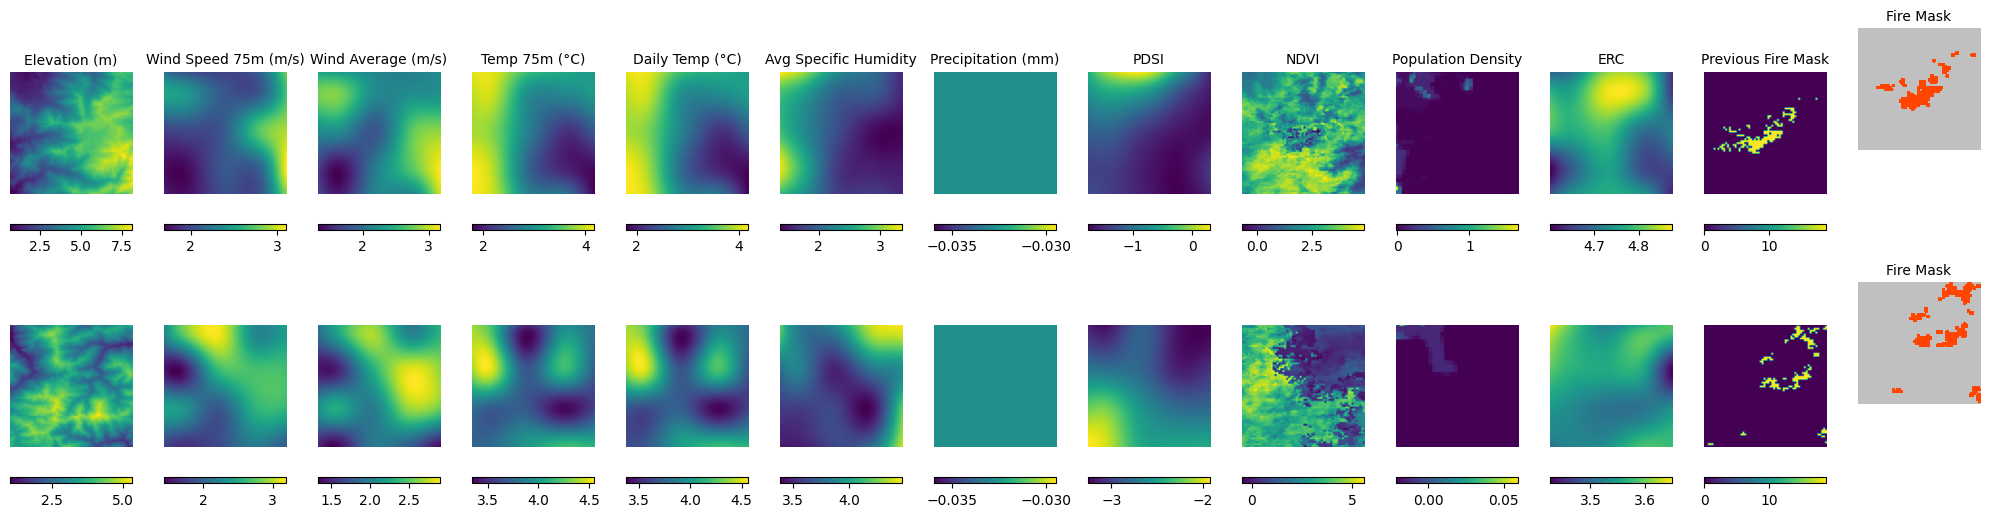

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_samples_from_dataloader(dataloader, n_rows=2):
    """
    Plots samples from a PyTorch DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): PyTorch DataLoader containing batches.
        n_rows (int): Number of rows (samples) to display.

    Returns:
        None
    """

    # Get one batch of data
    batch = next(iter(dataloader))
    inputs, labels = batch  # Shape: (batch_size, 64, 64, num_features), (batch_size, 64, 64, 1)
    
    batch_size, H, W, num_features = inputs.shape

    print("Input tensor shape:", inputs.shape)
    
    # Define colormap for fire mask
    CMAP_FIRE = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS_FIRE = [-1, -0.1, 0.001, 1]
    NORM_FIRE = colors.BoundaryNorm(BOUNDS_FIRE, CMAP_FIRE.N)

    # Feature titles (modify if needed)
    TITLES_WITH_UNITS = [
        "Elevation (m)", "Wind Speed 75m (m/s)", "Wind Average (m/s)", "Temp 75m (°C)", "Daily Temp (°C)",
        "Avg Specific Humidity", "Precipitation (mm)", "PDSI", "NDVI", "Population Density",
        "ERC", "Previous Fire Mask"
    ]

    fig, axes = plt.subplots(n_rows, num_features + 1, figsize=(20, 6))  # +1 for fire mask

    for i in range(n_rows):
        for j in range(num_features):  # Loop over features
            ax = axes[i, j] if n_rows > 1 else axes[j]  # Handle single row case
            
            # Plot feature map
            img = ax.imshow(inputs[i, :, :, j].numpy(), cmap='viridis')
            plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.1, fraction=0.05)
            
            # Set title for first row
            if i == 0 and j < len(TITLES_WITH_UNITS):
                ax.set_title(TITLES_WITH_UNITS[j], fontsize=10)

            ax.axis('off')

        # Plot fire mask in last column
        ax = axes[i, -1] if n_rows > 1 else axes[-1]
        img = ax.imshow(labels[i, :, :, 0].numpy(), cmap=CMAP_FIRE, norm=NORM_FIRE)
        ax.set_title("Fire Mask", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 🔹 Call the function to visualize 2 training samples
plot_samples_from_dataloader(train_loader, n_rows=2)


In [13]:
import os
import glob
import torch
from torch.utils.data import DataLoader

# 🔹 Dataset path
dataset_path = "ndws_western_dataset/"
train_files = glob.glob(os.path.join(dataset_path, "*.tfrecord"))

# 🔹 Load dataset
train_dataset = WildfireDataset(train_files)

# 🔹 Compute total samples and steps per epoch
BATCH_SIZE = 16  # Change based on your training config
num_samples = len(train_dataset)
STEPS_PER_EPOCH = num_samples // BATCH_SIZE

# 🔹 Print results
print(f"Total Samples: {num_samples}")
print(f"Steps Per Epoch: {STEPS_PER_EPOCH}")


Total Samples: 20097
Steps Per Epoch: 1256


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

# 🔹 UNet with ceil_mode pooling to avoid zero dimensions
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = DoubleConv(in_c, out_c)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
    def forward(self, x): return self.pool(self.double_conv(x))

class UpSample(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_c, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        x = nn.functional.pad(x, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([skip, x], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.middle = DoubleConv(512, 1024)
        self.up4 = UpSample(1024, 512)
        self.up3 = UpSample(512, 256)
        self.up2 = UpSample(256, 128)
        self.up1 = UpSample(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        xm = self.middle(x4)
        x = self.up4(xm, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        return self.final(x)

# 🔹 Dice Loss implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        p = probs.view(-1)
        t = targets.view(-1)
        inter = (p * t).sum()
        return 1 - (2 * inter + self.smooth) / (p.sum() + t.sum() + self.smooth)

# 🔹 Configuration
EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 8
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 🔹 Determine channel format and channels from the first sample
first_img, first_mask = train_dataset[0]
# Decide if image is channel-first (C,H,W) or channel-last (H,W,C)
if first_img.dim() == 3:
    # Compare first and last dims to guess
    if first_img.shape[0] <= first_img.shape[-1]:
        channel_format = 'first'
        in_channels = first_img.shape[0]
    else:
        channel_format = 'last'
        in_channels = first_img.shape[-1]
else:
    channel_format = 'last'
    in_channels = first_img.shape[-1]
# Masks assumed single-channel
out_channels = 1
print(f"Detected image channel_format={channel_format}, in_channels={in_channels}, out_channels={out_channels}")

# 🔹 Helper to permute channel-last to channel-first

def permute_if_needed(x: torch.Tensor, fmt: str, channels: int) -> torch.Tensor:
    if fmt == 'last' and x.dim() == 3:
        # For single example HWC
        return x.permute(2, 0, 1)
    if fmt == 'last' and x.dim() == 4 and x.shape[-1] == channels:
        return x.permute(0, 3, 1, 2)
    return x

# 🔹 Model, Losses, Optimizer, Scheduler
model = UNet(in_channels, out_channels).to(DEVICE)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
model = UNet(in_channels, out_channels).to(DEVICE)

Detected image channel_format=last, in_channels=12, out_channels=1


In [15]:
model.load_state_dict(torch.load("best_f1.pth"))

<All keys matched successfully>

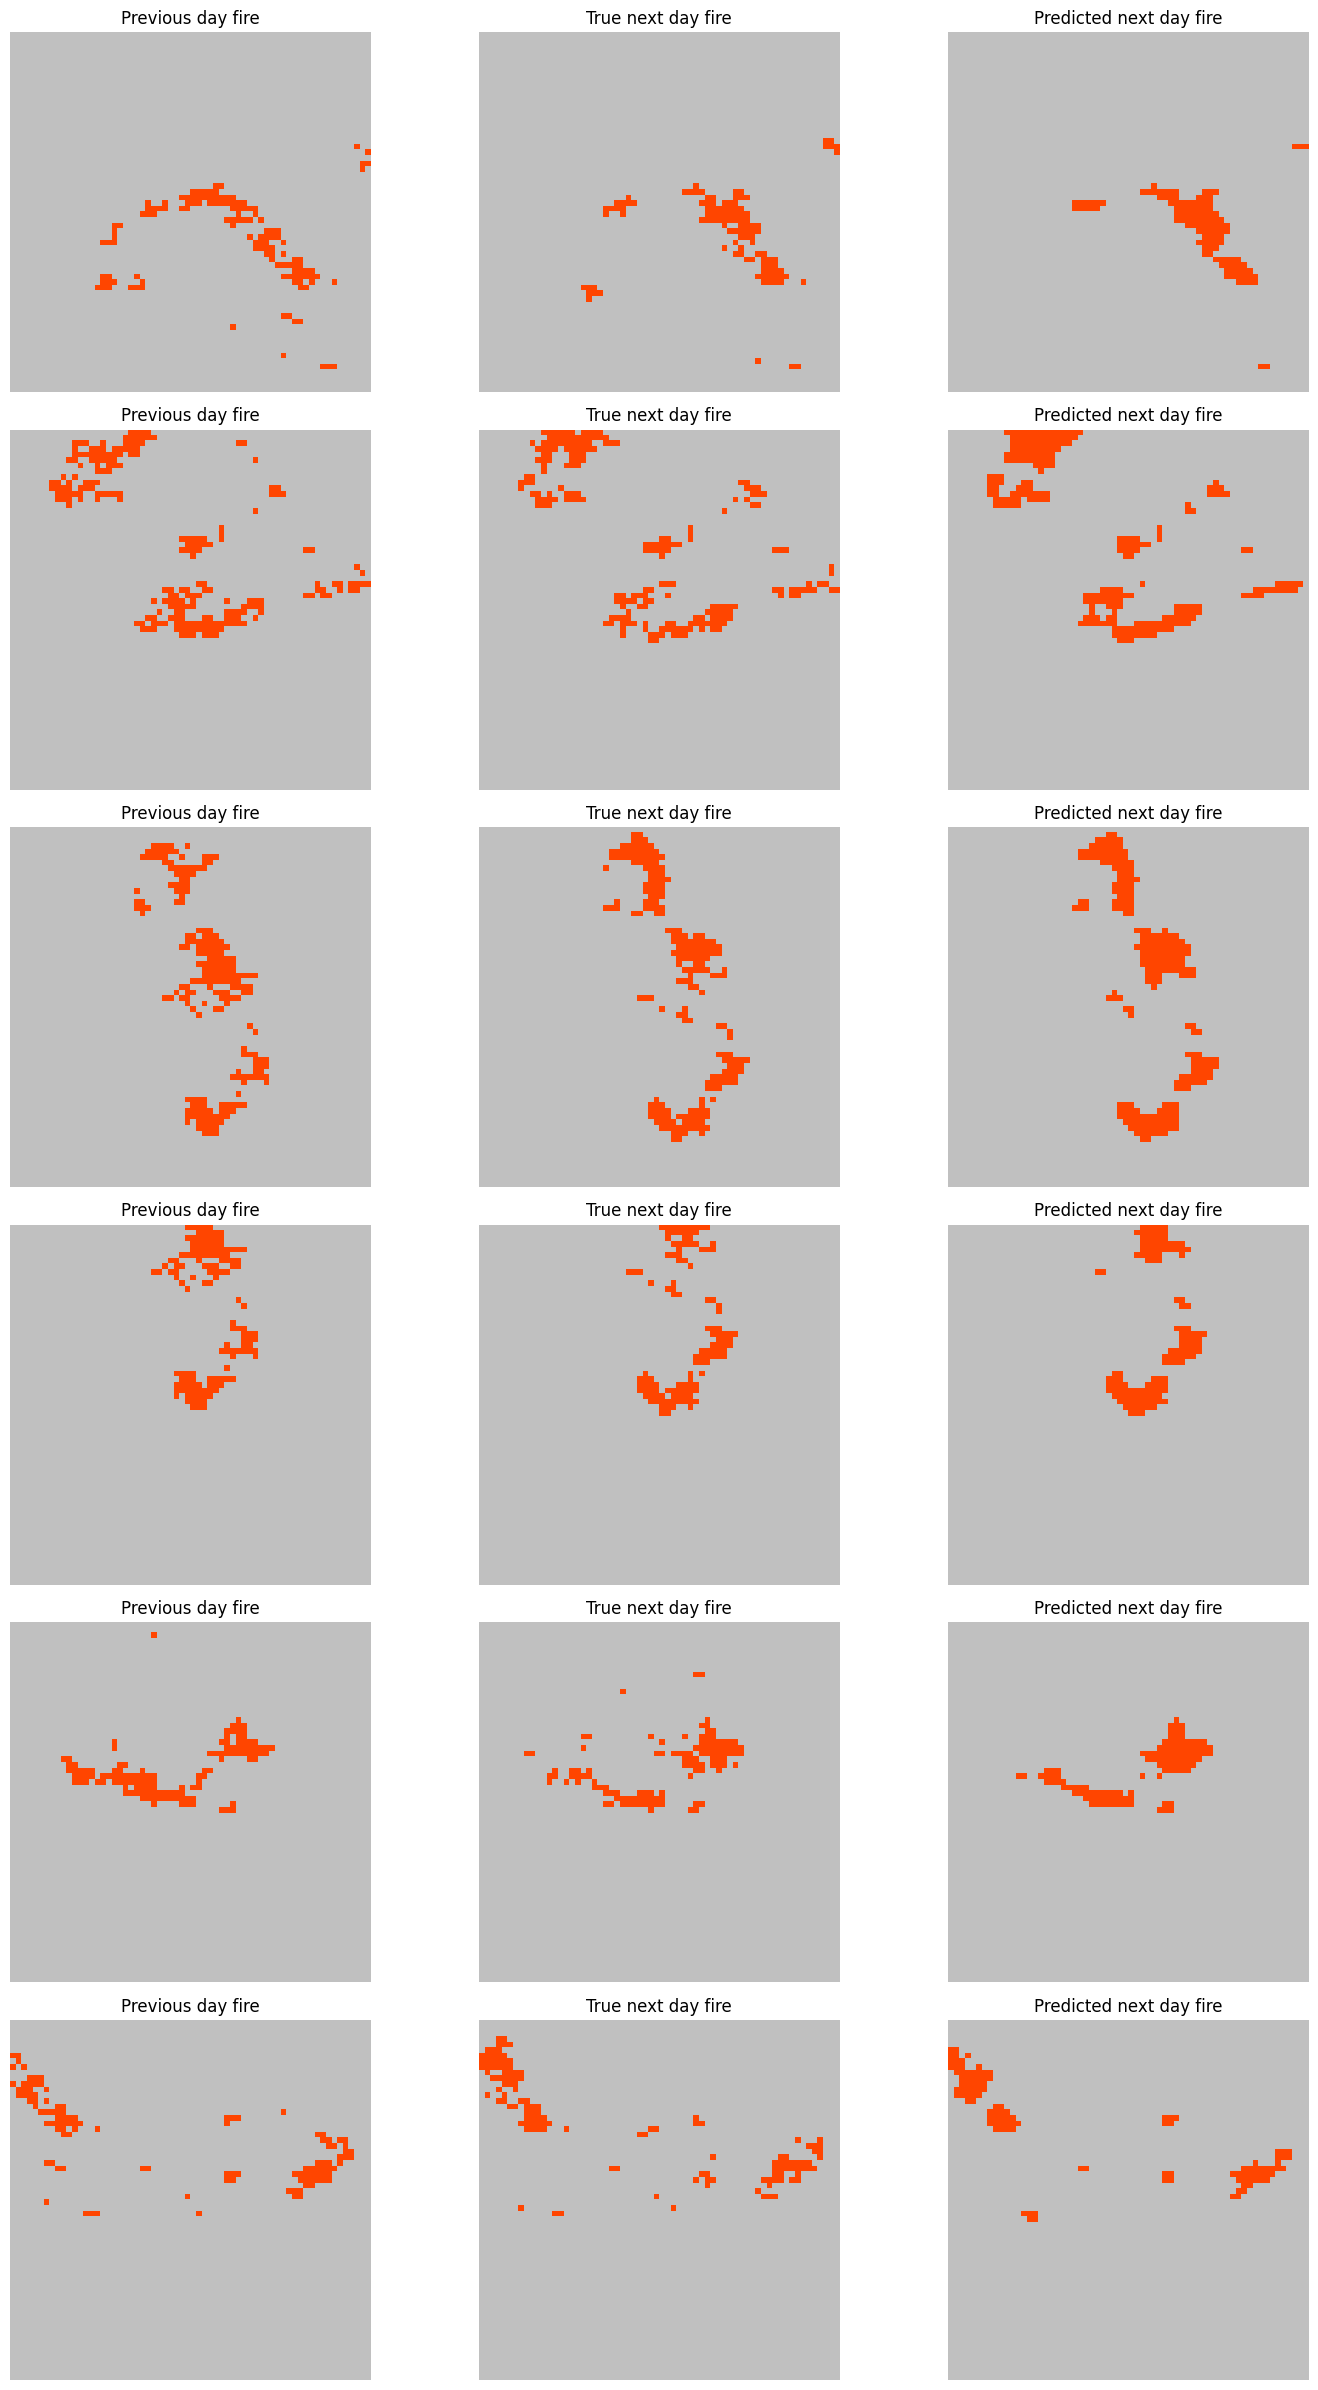

In [16]:
import random

# 🎨 Plot Predictions
from typing import Callable

def show_inference(n_rows: int, features: torch.Tensor, labels: torch.Tensor, prediction_function: Callable):
    """
    Show model inference through images.
    """
    from matplotlib import pyplot as plt
    from matplotlib import colors

    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15, n_rows * 4))
    predictions = prediction_function(features)

    for i in range(n_rows):
        plt.subplot(n_rows, 3, i * 3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i * 3 + 2)
        plt.title("True next day fire")
        plt.imshow(labels[i], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i * 3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(predictions[i, 0, :, :], cmap=CMAP, norm=NORM)
        plt.axis('off')    

    plt.tight_layout()
    plt.show()

def get_random_batch(test_loader):
    data_list = list(test_loader)  # Convert test_loader to a list of batches
    random_batch = random.choice(data_list)  # Randomly select one batch
    return random_batch

# Run inference plot with random samples
features, labels = get_random_batch(test_loader)
show_inference(6, features, labels, lambda x: (torch.sigmoid(model(permute_if_needed(x, channel_format, in_channels).float().to(DEVICE))) > 0.5).float().cpu().numpy())


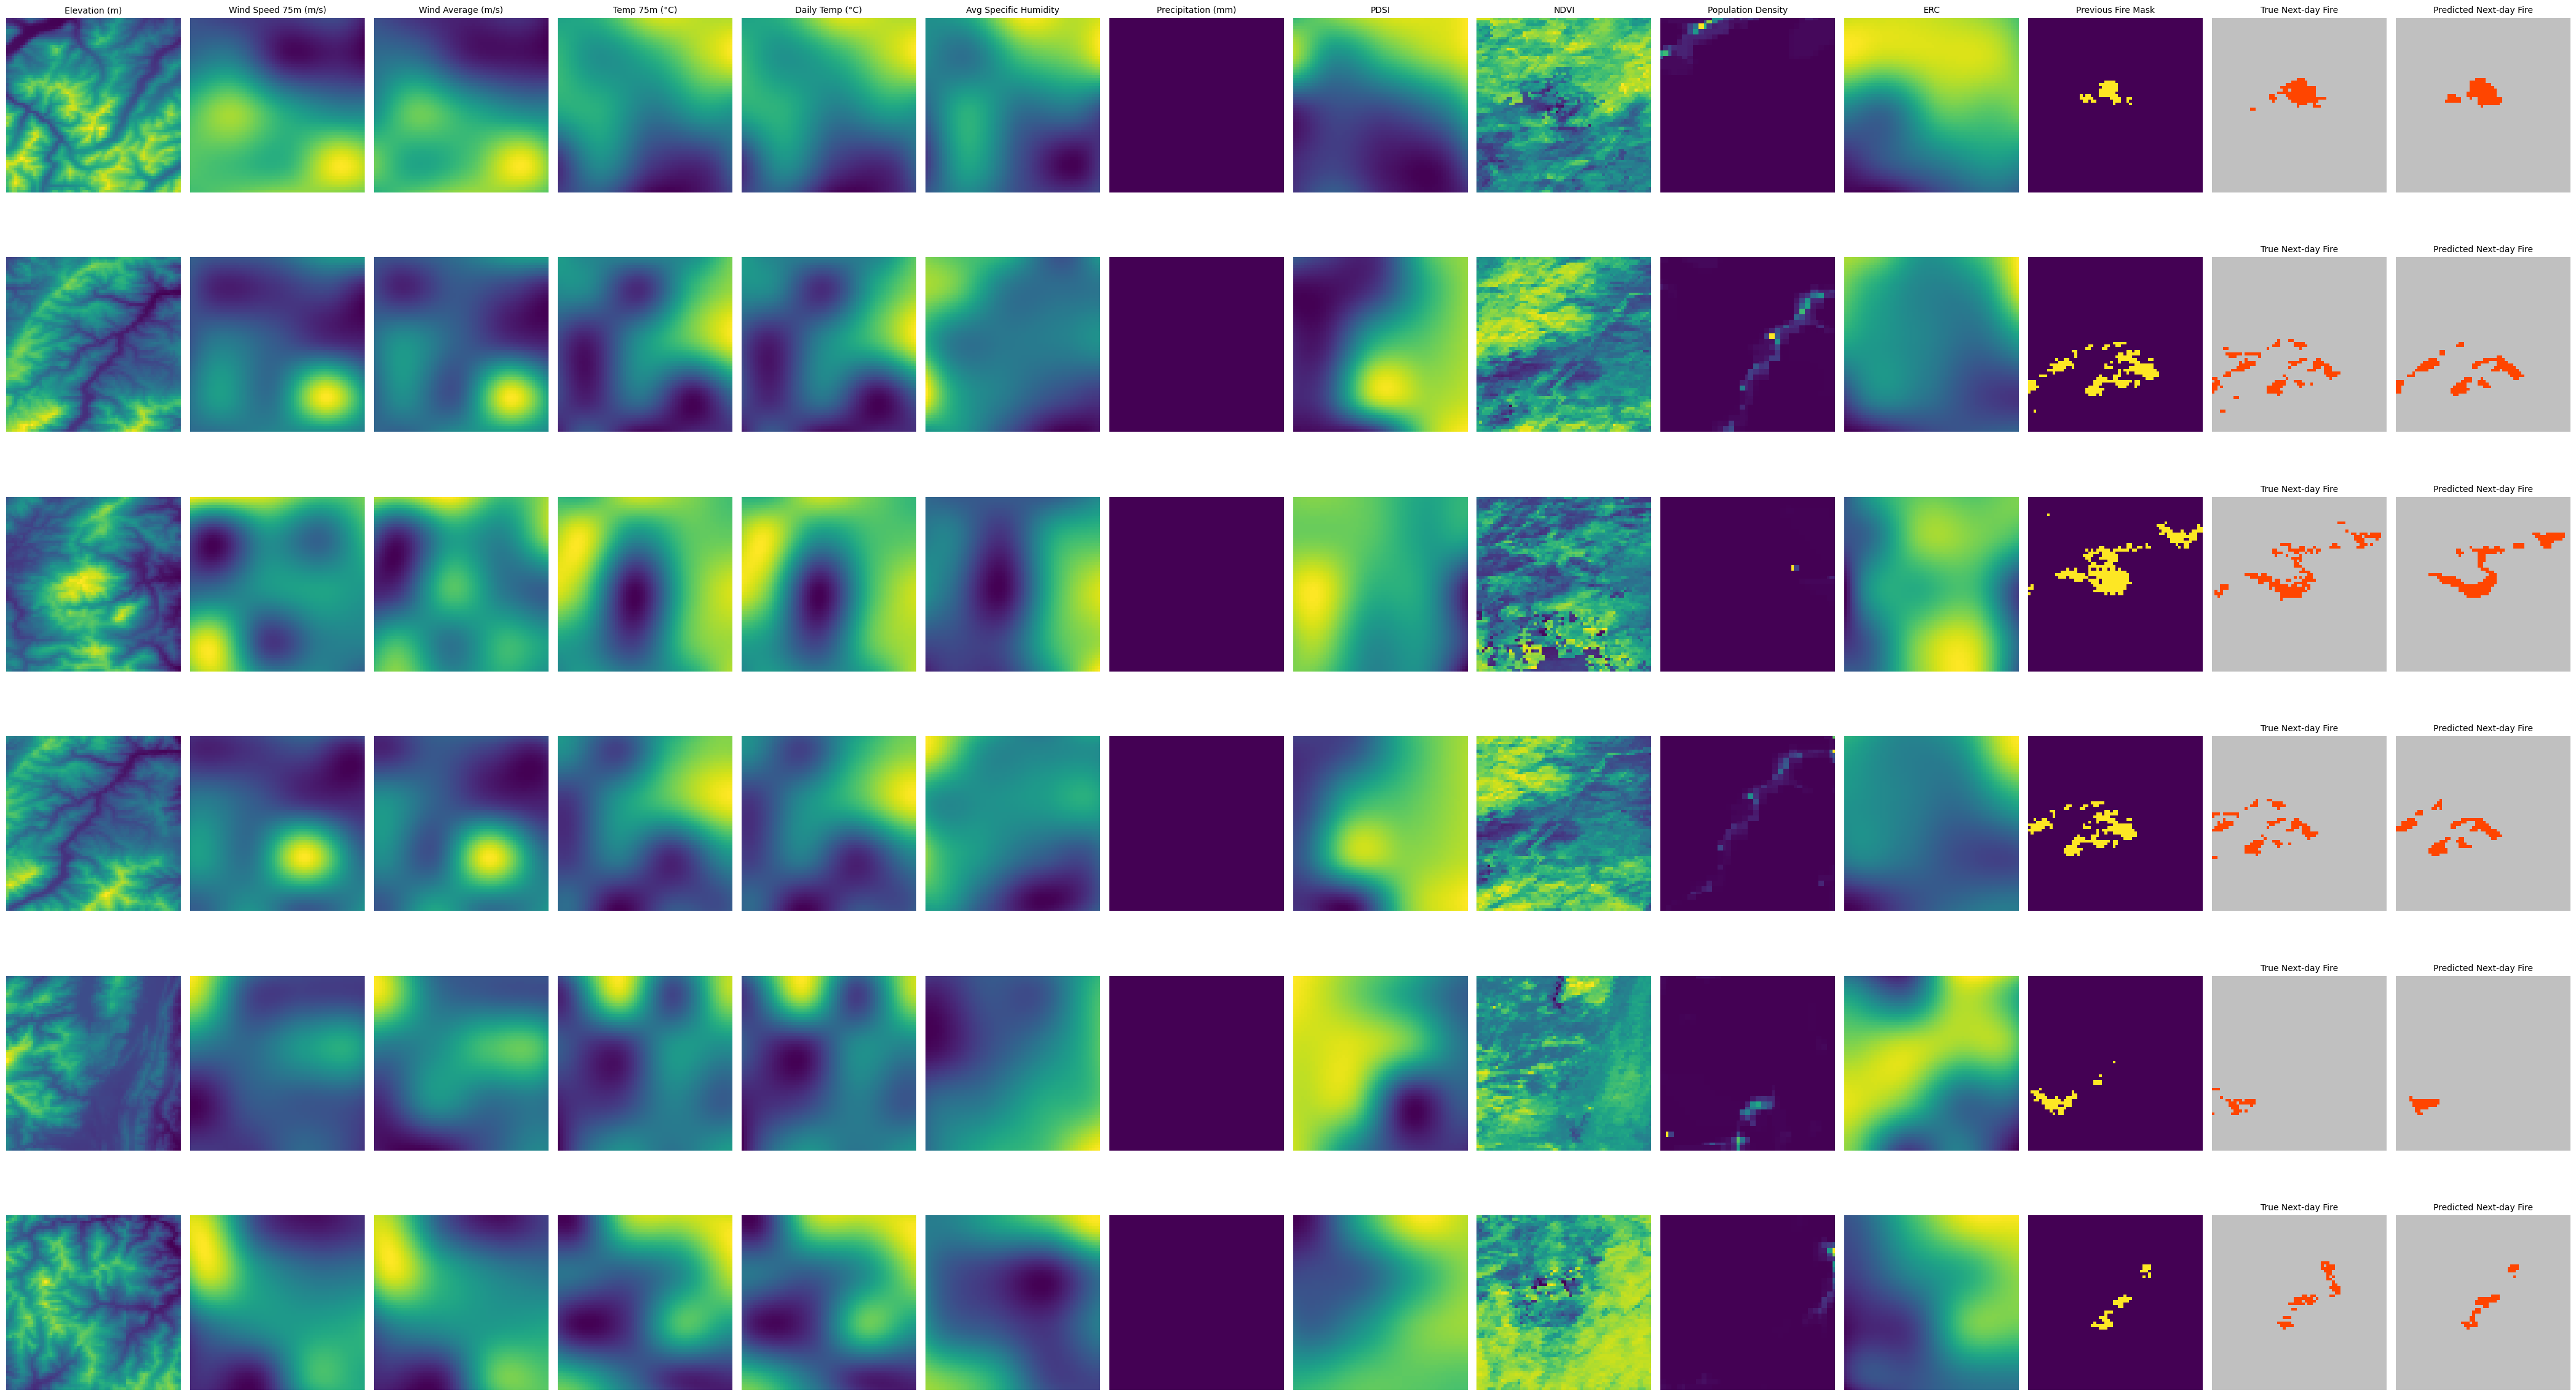

In [17]:
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def get_random_batch(dataloader):
    """
    Converts the dataloader into a list of batches and returns one chosen at random.
    """
    all_batches = list(dataloader)  # Note: this will iterate through the entire loader
    return random.choice(all_batches)


def plot_all_features_and_predictions(dataloader, model, permute_fn, fmt, in_ch, out_ch, n_rows=2):
    """
    Plots all feature channels, true next-day fire mask, and model predictions for random samples.
    """
    # Get one random batch
    inputs, labels = get_random_batch(dataloader)  # inputs: (B,H,W,C), labels: (B,1,H,W) or (B,H,W,1)
    batch_size, H, W, num_features = inputs.shape

    # Define colormap for fire mask
    CMAP_FIRE = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS_FIRE = [-1, -0.1, 0.001, 1]
    NORM_FIRE = colors.BoundaryNorm(BOUNDS_FIRE, CMAP_FIRE.N)

    # Feature titles (modify as needed)
    TITLES_WITH_UNITS = [
        "Elevation (m)", "Wind Speed 75m (m/s)", "Wind Average (m/s)", "Temp 75m (°C)", "Daily Temp (°C)",
        "Avg Specific Humidity", "Precipitation (mm)", "PDSI", "NDVI", "Population Density",
        "ERC", "Previous Fire Mask"
    ]

    # Prepare predictions
    x = permute_fn(inputs, fmt, in_ch).float().to(DEVICE)
    with torch.no_grad():
        preds = (torch.sigmoid(model(x)) > 0.5).cpu().numpy()  # (B,1,H,W)

    # Plot
    fig, axes = plt.subplots(n_rows, num_features + 2, figsize=(3*(num_features+2), 4*n_rows))
    for i in range(n_rows):
        for j in range(num_features):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            im = ax.imshow(inputs[i, :, :, j].numpy(), cmap='viridis')
            ax.axis('off')
            if i == 0 and j < len(TITLES_WITH_UNITS):
                ax.set_title(TITLES_WITH_UNITS[j], fontsize=10)

        # True next-day fire
        ax = axes[i, num_features] if n_rows > 1 else axes[num_features]
        im2 = ax.imshow(labels[i].numpy(), cmap=CMAP_FIRE, norm=NORM_FIRE)
        ax.set_title("True Next-day Fire", fontsize=10)
        ax.axis('off')

        # Predicted next-day fire
        ax = axes[i, num_features + 1] if n_rows > 1 else axes[num_features + 1]
        im3 = ax.imshow(preds[i, 0, :, :], cmap=CMAP_FIRE, norm=NORM_FIRE)
        ax.set_title("Predicted Next-day Fire", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example call: visualize 6 samples from a random batch of the test set
plot_all_features_and_predictions(
    test_loader,
    model,
    permute_if_needed,
    channel_format,
    in_channels,
    out_channels,
    n_rows=6
)
